In [1]:
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import pickle
import os
import shutil
import random
import copy
import uproot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import random
from sklearn.metrics import plot_confusion_matrix, roc_curve, accuracy_score 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [14]:
treeName="METTree"
dirPath="/home/zhelunli/Desktop/METtrigger/NTUP/"

MCfileNames=["user.cmerlass.410000.PowhegPythiaEvtGen_P2012_ttbar_hdamp172p5_nonallhad.r12400.v030521_bis_TREE.root",
          "user.cmerlass.345058.PowhegPythia8EvtGen_NNPDF3_AZNLO_ggZH125_vvbb.r12488.v040621_TREE.root",
           "user.cmerlass.361021.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ1W.r12488.v040621_TREE.root"
          ]
MCname=["ttbar","ggZH","JZ1"]
MCfilePaths=[dirPath+s for s in MCfileNames]
saveDir="/home/zhelunli/Desktop/METtrigger/plots"

if os.path.exists(saveDir):
    shutil.rmtree(saveDir)
    os.makedirs(saveDir)
else:
    os.makedirs(saveDir)


In [198]:
algList=["tcpufit","cell","trkmht","cvfpufit","pfopufit","mhtpufit_em_subjesgscIS","mhtpufit_pf_subjesgscIS",
        "pfsum_vssk","pfsum_cssk","L1"]

truthList=["NonIntPlusIntMuons","NonIntMinusIntMuons","NonInt","IntMuons","Int"]
singleList=["MCEventWeight","L1_XE50.isPassed","HLT_xe100_pfopufit_L1XE50.isPassed","HLT_xe110_tcpufit_L1XE50.isPassed","HLT_xe100_trkmht_xe85_tcpufit_xe65_cell_L1XE50.isPassed"]
variableList=[]

metList=[]
metPhiTrainList=[]
for alg in algList:
    variableList.append(alg+".met")
    variableList.append(alg+".phi")
    variableList.append(alg+".sumet")
    metList.append(alg+".met")
    metPhiTrainList.append(alg+".met")
    metPhiTrainList.append(alg+".phi")
    metPhiTrainList.append(alg+".sumet")
    
truthVarList=[]
for var in truthList:
    truthVarList.append("Truth."+var+".met")
    truthVarList.append("Truth."+var+".mpx")
    truthVarList.append("Truth."+var+".mpy")

In [26]:
def getDF(tree,processName,normWeight):
    input_tree=uproot.open(tree)
    df=input_tree.arrays(filter_name=variableList[0],library="pd")
    for i in range(1,len(variableList)):
        df=df.join(input_tree.arrays(filter_name=variableList[i],library="pd"))

    for i in range(0,len(truthVarList)):
        df=df.join(input_tree.arrays(filter_name=truthVarList[i],library="pd"))

    for i in range(0,len(singleList)):
        df=df.join(input_tree.arrays(filter_name=singleList[i],library="pd"))

    #convert to GeV
    df[variableList]=df[variableList]/1000.0
    df[truthVarList]=df[truthVarList]/1000.0
    #Setting truth MET to be The GIVEN MET for comparison 
    df['MET']=df['Truth.NonIntMinusIntMuons.met']
    df['process']=processName
    #normalize weight
    if normWeight:
        df['weight']=df['MCEventWeight']/df['MCEventWeight'].sum()
    else:
        df['weight']=df['MCEventWeight']
    print(processName," nUnweightedEvents=",df.shape[0])
    return df

In [64]:
normWeight=True
df=getDF(MCfilePaths[0]+":"+treeName,MCname[0],normWeight)
    
for i in range(1,len(MCfilePaths)):
    df=df.append(getDF(MCfilePaths[i]+":"+treeName,MCname[i],normWeight))


ttbar  nUnweightedEvents= 100000
ggZH  nUnweightedEvents= 100000
JZ1  nUnweightedEvents= 100000


In [65]:
df["isSignal"]=0
df.loc[df["Truth.NonIntMinusIntMuons.met"]>150,"isSignal"]=1

In [66]:
y=df.pop("isSignal")

In [67]:
df.columns

Index(['tcpufit.met', 'tcpufit.phi', 'tcpufit.sumet', 'cell.met', 'cell.phi',
       'cell.sumet', 'trkmht.met', 'trkmht.phi', 'trkmht.sumet',
       'cvfpufit.met', 'cvfpufit.phi', 'cvfpufit.sumet', 'pfopufit.met',
       'pfopufit.phi', 'pfopufit.sumet', 'mhtpufit_em_subjesgscIS.met',
       'mhtpufit_em_subjesgscIS.phi', 'mhtpufit_em_subjesgscIS.sumet',
       'mhtpufit_pf_subjesgscIS.met', 'mhtpufit_pf_subjesgscIS.phi',
       'mhtpufit_pf_subjesgscIS.sumet', 'pfsum_vssk.met', 'pfsum_vssk.phi',
       'pfsum_vssk.sumet', 'pfsum_cssk.met', 'pfsum_cssk.phi',
       'pfsum_cssk.sumet', 'L1.met', 'L1.phi', 'L1.sumet',
       'Truth.NonIntPlusIntMuons.met', 'Truth.NonIntPlusIntMuons.mpx',
       'Truth.NonIntPlusIntMuons.mpy', 'Truth.NonIntMinusIntMuons.met',
       'Truth.NonIntMinusIntMuons.mpx', 'Truth.NonIntMinusIntMuons.mpy',
       'Truth.NonInt.met', 'Truth.NonInt.mpx', 'Truth.NonInt.mpy',
       'Truth.IntMuons.met', 'Truth.IntMuons.mpx', 'Truth.IntMuons.mpy',
       'Truth.Int.

In [68]:
df[df['process']=='ttbar']['weight'].sum()

1.0

In [69]:
df[df['process']=='ggZH']['weight'].sum()

0.99999994

In [70]:
df[df['process']=='JZ1']['weight'].sum()

1.0000001

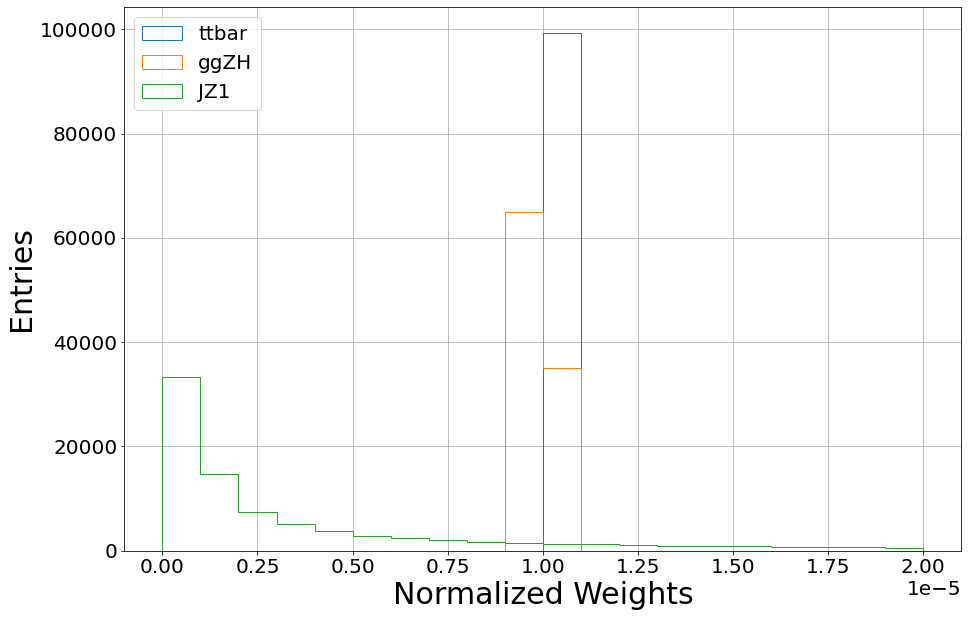

In [82]:
fig=plt.figure(0,figsize=(15,10))
df[df['process']=='ttbar']['weight'].hist(bins=np.arange(0,0.00002,0.000001),histtype='step',label='ttbar')
df[df['process']=='ggZH']['weight'].hist(bins=np.arange(0,0.00002,0.000001),histtype='step',label='ggZH')
df[df['process']=='JZ1']['weight'].hist(bins=np.arange(0,0.00002,0.000001),histtype='step',label='JZ1')
plt.legend()
plt.ylabel("Entries",size=30)
plt.xlabel("Normalized Weights",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.legend(loc=2,prop={'size': 20})
#plt.text(1.2e-5,6e4,r'Normalized weights',size=30)
fig.savefig(saveDir+"/weights.pdf")
plt.show()

Training

decide here whether to only work in one of the input samples

In [83]:
#All
X_trainAll, X_testAll, y_trainAll, y_testAll = train_test_split(df, y, test_size=0.5, random_state=0)
X_validAll, X_testAll, y_validAll, y_testAll = train_test_split(X_testAll, y_testAll, test_size=0.5, random_state=0)

#Training on those which passed L1
X_train=X_trainAll[X_trainAll["L1_XE50.isPassed"]==1].copy()
X_valid=X_validAll[X_validAll["L1_XE50.isPassed"]==1].copy()
X_test=X_testAll[X_testAll["L1_XE50.isPassed"]==1].copy()

y_train=y_trainAll[X_trainAll["L1_XE50.isPassed"]==1].copy()
y_valid=y_validAll[X_validAll["L1_XE50.isPassed"]==1].copy()
y_test=y_testAll[X_testAll["L1_XE50.isPassed"]==1].copy()


In [157]:
time0=time.time()
clf = LogisticRegression(random_state=0,max_iter=200000).fit(X_train[metList], y_train,sample_weight=X_train['weight'])
time1=time.time()
print("training time : ",time1-time0)
print('training score: ',clf.score(X_train[metList], y_train,sample_weight=X_train['weight']))
print('validation score: ',clf.score(X_valid[metList], y_valid,sample_weight=X_valid['weight']))

training time :  3.0101895332336426
training score:  0.8728249122947354
validation score:  0.869727488675166


In [199]:
time0=time.time()
clf_metPhi = LogisticRegression(random_state=0,max_iter=500000).fit(X_train[metPhiTrainList], y_train,sample_weight=X_train['weight'])
time1=time.time()
print("training time : ",time1-time0)
print('training score: ',clf_metPhi.score(X_train[metPhiTrainList], y_train,sample_weight=X_train['weight']))
print('validation score: ',clf_metPhi.score(X_valid[metPhiTrainList], y_valid,sample_weight=X_valid['weight']))

training time :  10.694133758544922
training score:  0.8742354985225683
validation score:  0.8709800938961595


In [201]:
def checkPR(alg,cut,X_valid,y_valid):
    passedX=X_valid[X_valid[alg]>=cut]
    passedY=y_valid[X_valid[alg]>=cut]
    fpr=passedX[passedY==0]['weight'].sum()/X_valid[y_valid==0]['weight'].sum()
    tpr=passedX[passedY==1]['weight'].sum()/X_valid[y_valid==1]['weight'].sum()
    return fpr,tpr

In [202]:
fpr,tpr,thresholds=roc_curve(y_valid,clf.predict_proba(X_valid[metList]).T[1],sample_weight=X_valid['weight'])

tc_fpr=[]
tc_tpr=[]

pfo_fpr=[]
pfo_tpr=[]

trkmht_fpr=[]
trkmht_tpr=[]
for i in range(100):
    cut=0+i*5
    
    pr=checkPR("tcpufit.met",cut,X_valid,y_valid)
    tc_fpr.append(pr[0])
    tc_tpr.append(pr[1])
    
    pr=checkPR("pfopufit.met",cut,X_valid,y_valid)
    pfo_fpr.append(pr[0])
    pfo_tpr.append(pr[1])
    
    pr=checkPR("trkmht.met",cut,X_valid,y_valid)
    trkmht_fpr.append(pr[0])
    trkmht_tpr.append(pr[1])
    

In [203]:
#testProcess='ggZH'
#fpr,tpr,thresholds=roc_curve(y_valid[X_valid['process']==testProcess],clf.predict_proba(X_valid[X_valid['process']==testProcess][metList]).T[1],sample_weight=X_valid[X_valid['process']==testProcess]['weight'])
fpr,tpr,thresholds=roc_curve(y_valid,clf.predict_proba(X_valid[metList]).T[1],sample_weight=X_valid['weight'])

fpr_metPhi,tpr_metPhi,thresholds=roc_curve(y_valid,clf_metPhi.predict_proba(X_valid[metPhiTrainList]).T[1],sample_weight=X_valid['weight'])

tc_fpr=[]
tc_tpr=[]

pfo_fpr=[]
pfo_tpr=[]

trkmht_fpr=[]
trkmht_tpr=[]
for i in range(100):
    cut=0+i*5
    
    pr=checkPR("tcpufit.met",cut,X_valid,y_valid)
    tc_fpr.append(pr[0])
    tc_tpr.append(pr[1])
    
    pr=checkPR("pfopufit.met",cut,X_valid,y_valid)
    pfo_fpr.append(pr[0])
    pfo_tpr.append(pr[1])
    
    pr=checkPR("trkmht.met",cut,X_valid,y_valid)
    trkmht_fpr.append(pr[0])
    trkmht_tpr.append(pr[1])
    

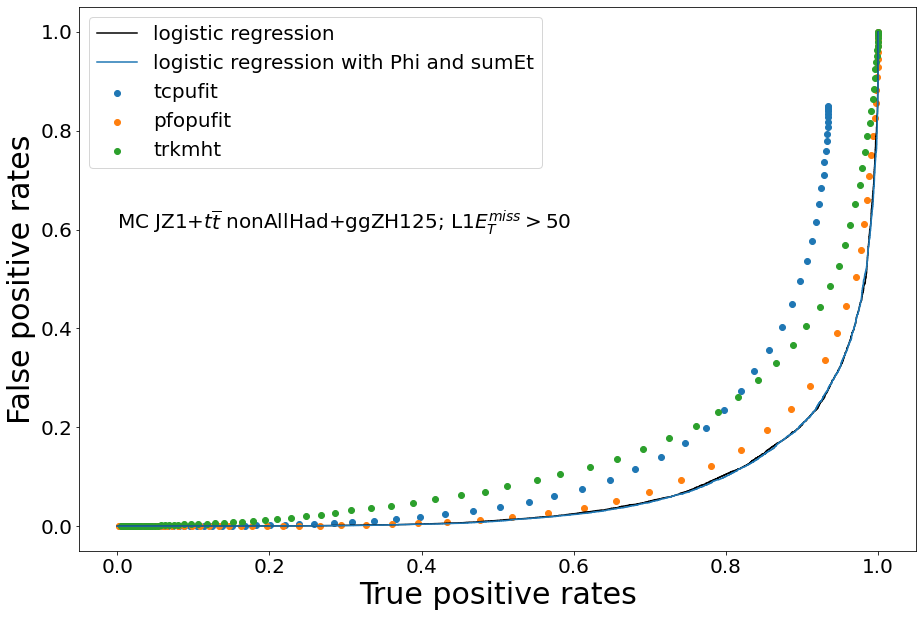

In [205]:
fig=plt.figure(2,figsize=(15,10))
plt.scatter(tc_tpr,tc_fpr,label='tcpufit')
plt.scatter(pfo_tpr,pfo_fpr,label='pfopufit')
plt.scatter(trkmht_tpr,trkmht_fpr,label='trkmht')
#plt.scatter(HLT_xe110_tcpufit_L1XE50_tpr,HLT_xe110_tcpufit_L1XE50_fpr,label='HLT_xe110_tcpufit_L1XE50',marker='P')
plt.plot(tpr, fpr,label='logistic regression',color='k')
plt.plot(tpr_metPhi, fpr_metPhi,label='logistic regression with Phi and sumEt')
plt.ylabel("False positive rates",size=30)
plt.xlabel("True positive rates",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.text(0.0,0.6,r'MC $t\overline{t}$ nonAllHad; L1$E_{T}^{miss}>50$',size=30)
plt.text(0.0,0.6,r'MC JZ1+$t\overline{t}$ nonAllHad+ggZH125; L1$E_{T}^{miss}>50$',size=20)
#plt.yscale('log')
#plt.xlim(0.5,1.0)
plt.legend(loc='best',prop={'size': 20})
plt.show()
fig.savefig(saveDir+"/ROC_.pdf")
plt.close(fig)

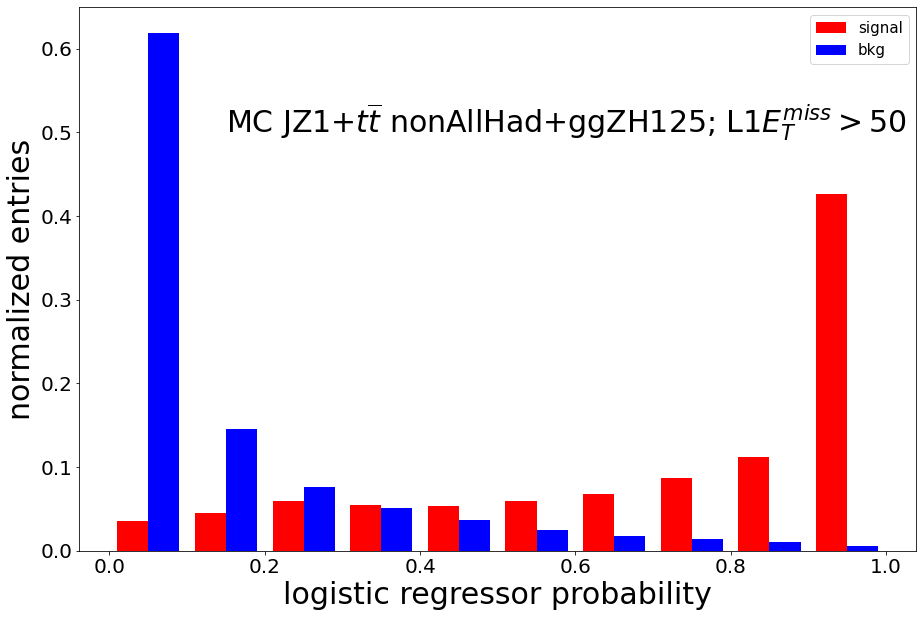

In [140]:
figProb=plt.figure(3,figsize=(15,10))
step=0.1
bins=np.arange(0,1+step,step)

#first prob out of predict is class 0 which is bkg. This is easily checked
pred=np.array([clf.predict_proba(X_valid[y_valid==1][metList]).T[1],clf.predict_proba(X_valid[y_valid==0][metList]).T[1]])

       
label=["signal","bkg"]
color=['r','b']
probBins=np.histogram(pred[1],bins=bins)[1]
plt.hist(pred,bins=bins,color=color,label=label,weights=[X_valid[y_valid==1]['weight']/X_valid[y_valid==1]['weight'].sum(),X_valid[y_valid==0]['weight']/X_valid[y_valid==0]['weight'].sum()])
plt.xlabel("logistic regressor probability",size=30)
plt.ylabel("normalized entries",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.text(0.0,0.4,r'MC ggZH125; L1$E_{T}^{miss}>50$',size=30)
plt.text(0.15,0.5,r'MC JZ1+$t\overline{t}$ nonAllHad+ggZH125; L1$E_{T}^{miss}>50$',size=30)
plt.legend(loc='best',prop={'size': 15})
plt.show()
figProb.savefig(saveDir+"/Prob_.pdf")
plt.close(figProb)


In [141]:
X_valid["prob"]=clf.predict_proba(X_valid[metList]).T[1]

In [152]:
cutbins=[]
cutbinsBar=[]
bar=5
counter=bar
for i in range(30):
    cutbins.append(counter)
    cutbinsBar.append(bar)
    counter+=2*bar   

In [153]:
def getEfficiency(algPassed,truth,cutbins):
    eff=[]
    #getThose which passed this algorithm's selection
    tmpX=X_validAll[X_validAll[algPassed]==1]
    for i in range(len(cutbins)):
        selected=tmpX[(tmpX[truth]<(cutbins[i]+bar))&(tmpX[truth]>(cutbins[i]-bar))]['weight'].sum()
        All=X_validAll[(X_validAll[truth]>(cutbins[i]-bar))&(X_validAll[truth]<(cutbins[i]+bar))]['weight'].sum()
        eff.append(selected/All)
    return eff

def getEfficiencyLogistic(prob,truth,cutbins):
    eff=[]
    for i in range(len(cutbins)):
        selected=X_valid[(X_valid["prob"]>prob)&(X_valid[truth]<(cutbins[i]+bar))&(X_valid[truth]>(cutbins[i]-bar))]['weight'].sum()
        All=X_validAll[(X_validAll[truth]>(cutbins[i]-bar))&(X_validAll[truth]<(cutbins[i]+bar))]['weight'].sum()       
        eff.append(selected/All)
    return eff

In [154]:

L1_XE50_eff=getEfficiency("L1_XE50.isPassed","MET",cutbins)
HLT_xe100_pfopufit_L1XE50_eff=getEfficiency("HLT_xe100_pfopufit_L1XE50.isPassed","MET",cutbins)
HLT_xe110_tcpufit_L1XE50_eff=getEfficiency("HLT_xe110_tcpufit_L1XE50.isPassed","MET",cutbins)
HLT_xe100_trkmht_xe85_tcpufit_xe65_cell_L1XE50_eff=getEfficiency("HLT_xe100_trkmht_xe85_tcpufit_xe65_cell_L1XE50.isPassed","MET",cutbins)
logi_eff015=getEfficiencyLogistic(0.15,"MET",cutbins)
logi_eff05=getEfficiencyLogistic(0.5,"MET",cutbins)
logi_eff02=getEfficiencyLogistic(0.2,"MET",cutbins)

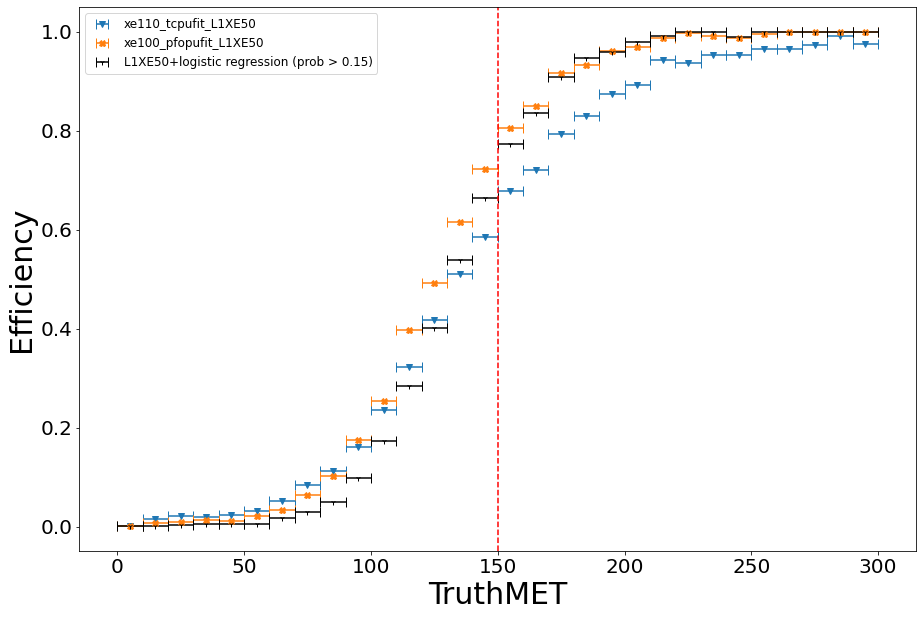

In [155]:
fig=plt.figure(4,figsize=(15,10))
plt.errorbar(cutbins,HLT_xe110_tcpufit_L1XE50_eff,xerr=cutbinsBar,label='xe110_tcpufit_L1XE50',fmt='v',capsize=5)
plt.errorbar(cutbins,HLT_xe100_pfopufit_L1XE50_eff,xerr=cutbinsBar,label='xe100_pfopufit_L1XE50',fmt='X',capsize=5)
#plt.errorbar(cutbins,L1_XE50_eff,xerr=cutbinsBar,label='L1XE50',fmt='.',capsize=5)
#plt.errorbar(cutbins,HLT_xe100_trkmht_xe85_tcpufit_xe65_cell_L1XE50_eff,xerr=cutbinsBar,label='xe100_trkmht_xe85_tcpufit_xe65_cell_L1XE50',fmt='.',capsize=5)
plt.errorbar(cutbins,logi_eff015,xerr=cutbinsBar,color='k',label='L1XE50+logistic regression (prob > 0.15)',fmt='1',capsize=5)
#plt.errorbar(cutbins,logi_eff05,xerr=cutbinsBar,label='L1XE50+logistic regression (prob > 0.5)',fmt='.',capsize=5,color='k')
#plt.errorbar(cutbins,logi_eff02,xerr=cutbinsBar,label='logistic regression (prob > 0.2)',fmt='.',capsize=5)
plt.ylabel("Efficiency",size=30)
plt.xlabel("TruthMET",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.text(250,0.3,r'MC ggZH125',size=30)
#plt.text(250,0.3,r'MC $t\overline{t}$ nonAllHad',size=30)
plt.axvline(x=150,linestyle='--',color='r')
plt.legend(loc='best',prop={'size': 12})
plt.show()
fig.savefig(saveDir+"/effPt.pdf")
plt.close(fig)